#Đoạn này là preprocessing

In [146]:
pip install pyvi

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics import classification_report

In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/NLP/dataset_final_nlp.csv")

In [150]:
data = data.dropna()

In [151]:
data.head()

,review,label
0,shop quá tệ đặt màu trắng giao màu xanh,0
1,mình rất hài lòng với sản phẩm của shop\nhàng ...,1
2,hình ảnh chỉ mang tính chất nhận xu hàng về nh...,1
3,sản phẩm thì như hình minh họa giao hàng nhanh...,1
4,sản phẩm chất lượng đã mua cái thứ 2 rẻ hơn cá...,1


In [152]:
sentences = data['review']

In [153]:
label_counts = data['label'].value_counts()

In [154]:
print(label_counts)

1    4236
0    3778
2    1139
Name: label, dtype: int64


In [155]:
# Chuẩn hóa văn bản
data['review'] = data['review'].str.lower()
data['review'] = data['review'].replace('[^\w\s]', '', regex=True)


In [156]:
data.head()

,review,label
0,shop quá tệ đặt màu trắng giao màu xanh,0
1,mình rất hài lòng với sản phẩm của shop\nhàng ...,1
2,hình ảnh chỉ mang tính chất nhận xu hàng về nh...,1
3,sản phẩm thì như hình minh họa giao hàng nhanh...,1
4,sản phẩm chất lượng đã mua cái thứ 2 rẻ hơn cá...,1


In [157]:
X = data['review']
y = data['label']

In [158]:
X.shape

(9153,)

In [159]:
import re
def chuyen_viet_tat(s):

    tu_dien_viet_tat = {
    r'\bmn\b': 'mọi người',
    r'\bsp\b': 'sản phẩm',
    r'\bđc\b': 'được',
    r'\bnhah\b': 'nhanh',
    r'\bhong\b': 'không',
    r'\bk\b': 'không',
    r'\bthui\b': 'thôi',
    r'\be\b': 'em',
    r'\bgh\b': 'giao hàng',
    r'\bnhư v\b': 'như vậy',
    r'\btr\b': 'trời',
    r'\bon\b': 'ổn',
    r'\bnma\b': 'nhưng mà',
    r'\bnm\b': 'nhưng mà',
    r'\bkhéc\b': 'khét',
    r'\bhih\b': 'hình',
    r'\bqc\b': 'quảng cáo',
    r'\bt2\b': 'thứ hai',
    r'\bsd\b': 'sử dụng',
    r'\bhcm\b': 'hồ chí minh',
    r'\bhn\b': 'hà nội',
    r'\bcmt\b': 'comment',
    r'\bng\b': 'người',
    r'\bsr\b': 'xin lỗi',
    r'\blg\b': 'lượng',
    r'\bhsd\b': 'hạn sử dụng',
    r'\bhok\b': 'không',
    r'\bh\b': 'giờ',
    r'\bae\b': 'anh em',
    r'\bnt\b': 'nhắn tin',
    r'\bsop\b': 'shop',
    r'\bln\b': 'luôn',
    r'\btrc\b': 'trước',
    r'\bthik\b': 'thích',
    r'\bmk\b': 'mình',
    r'\bsx\b': 'sản xuất',
    r'\bnhug\b': 'nhưng',
    r'\bsl\b': 'số lượng',
    r'\bthank\b': 'cảm ơn',
    r'\bthanks\b': 'cảm ơn',
    r'\bnka\b': 'nha',
    r'\bthowm\b': 'thơm',
    r'\bchuwa\b': 'chưa',
    r'\bbic\b': 'biết',
    r'\bgood\b': 'tốt',
    r'\bgod\b': 'tốt',
    r'\btn\b': 'tin nhắn',
    r'\bđươcj\b': 'được',
    r'\bvs\b': 'với',
    r'\bdk\b': 'được',
    r'\br\b': 'rồi',
    r'\bmjh\b': 'mình',
    r'\bntn\b': 'như thế nào',
    r'\bbit\b': 'biết',
    r'\bkm\b': 'khuyến mãi',
    r'\bmng\b': 'mọi người',
    r'\bcx\b': 'cũng',
    r'\btt\b': 'tiếp tục',
    r'\bcl\b': 'chất lượng',
    r'\bktra\b': 'kiểm tra',
    r'\bktr\b': 'kiểm tra',
    r'\bz\b': 'vậy',
    r'\bb\b': 'bạn',
    r'\bkbt\b': 'không biết',
    r'\bj\b': 'gì',
    r'\bđt\b': 'điện thoại',
    r'\blụong\b': 'lượng',
    r'\bkaij\b': 'lại',
    r'\bhk\b': 'không',
    r'\bko\b': 'không',
    r'\bđưj\b': 'được',
    r'\bbidy\b': 'body',
    r'\boki\b': 'ok',
    r'\bnv\b': 'nhân viên',
    r'\bchx\b': 'chưa',
    r'\bbt\b': 'biết',
    r'\bnhm\b': 'nhưng mà',
    r'\bwa\b': 'quá',
    r'\bchâm\b': 'chậm',
    r'\bkhum\b': 'không',
    r'\bchac\b': 'chắc',
    r'\bcjhâm\b': 'chậm',
    r'\bahop\b': 'shop',
    r'\bxme\b': 'xem',
    r'\bđnahs\b': 'đánh',
    r'\bnghũ\b': 'nghĩ',
    r'\btrỏng\b': 'trong',
    r'\bokela\b': 'ok',
    r'\btks\b': 'cảm ơn',
    r'\bcùa\b': 'của',
    r'\bơt\b': 'ở',
    r'\bksao\b': 'không sao',
    r'\bokelah\b': 'ok',
    r'\bmụi\b': 'mọi',
    r'\bngừoi\b': 'người',
    r'\bmac\b': 'mác',
    r'\bhfgng\b': 'hàng',
    r'\bgg\b': 'giảm giá',
    r'\bap\b': 'áp',
    r'\bdc\b': 'được',
    r'\bmag\b': 'mang',
    r'\bbs\b': 'bác sĩ',
    r'\bthươgf\b': 'thường',
    r'\btu van\b': 'tư vấn',
    r'\btgian\b': 'thời gian',
    r'\bch\b': 'chưa',
    r'\btg\b': 'thời gian',
    r'\bcbi\b': 'chuẩn bị',
    r'\bngưồi\b': 'người',
    r'\bnhê\b': 'nha',
    r'\bni\b': 'này',
    r'\b\fai\b': "phải",
     r'\bship pơ\b': "shipper",
    r'\bhiêun\b': 'hiệu',
    r'\btố\b': 'tốt',
    r'\btuýt\b': 'tuýp',
    r'\bnx\b': 'nữa',
    r'\btw\b': 'trung ương',
    r'\blm\b': 'làm',
    r'\bqq\b': 'quần què',
    r'\bzire\b': 'size',
    r'\bđâh\b': 'đâu',
    r'\blun\b': 'luôn',
    r'\bphake\b': 'fake',
    r'\blonn\b': 'lol',
    r'\bchổ\b': 'chỗ',
    r'\bquâ\b': 'quá',
    r'\bsít\b': 'shit',
    r'\bdb\b': 'đầu_buồi',
    r'\bchày\b': 'trầy',
    r'\bqa\b': 'quá',
    r'\bns\b': 'nó',
    r'\bbôg\b': 'bông',
    r'\bxâu\b': 'xấu',
    r'\blh\b': 'liên hệ',
    r'\bll\b': 'liên lạc',
    r'\bgioa\b': 'giao',
    r'\bnheng\b': 'nhưng',
    r'\bak\b': 'á',
    r'\bphẩn\b': 'phẩm',
    r'\bcám\b': 'cảm',
    r'\bah\b': 'á',
    r'\bokey\b': 'ok',
    r'\blứm\b': 'lắm',
    r'\btoẹt\b': 'tuyệt',
    r'\bkím\b': 'kiếm',
    r'\bgood\b': 'tốt',
    r'\btq\b': 'trung quốc',
    r'\btiệc vời\b': 'tuyệt vời',
    r'\bcunhx\b': 'cũng',
    r'\bm\b': 'mình',
    r'\bspham\b': 'sản phẩm',
    r'\bks\b': 'không sao',
    r'\btieenf\b': 'tiền',
    r'\bqt\b': 'quốc tế',
    r'\bnhunge\b': 'nhưng',
    r'\bphaamf\b': 'phẩm',
    r'\bbk\b': 'biết',
    r'\bcos\b': 'có',
    r'\btot\b': 'tốt',
    r'\bkh\b': 'khách hàng',
    r'\bnod\b': 'nó',
    r'\brui\b': 'rồi',
    r'\btrk\b': 'trước',
    r'\bkg\b': 'không',
    r'\bđx\b': 'được',
    r'\bđưocj\b': 'được',
    r'\blzd\b': 'lazada',
    r'\bshipper\b': 'shiper',
    r'\bnhưnh\b': 'nhưng',
    r'\bnhung\b': 'nhưng',
    r'\bokie\b': 'ok',
    r'\bb\b': 'bạn',
    r'\bph\b': 'phẩm',
    r'\bsez\b': 'sẽ',
    r'\bđng\b': 'đóng',
    r'\bcb\b': 'chuẩn bị',
    r'\bđươ\b': 'được',
    r'\blượg\b': 'lượng',
    r'\bđươc\b': 'được',
    r'\batvs\b': 'an toàn vệ sinh',
    r'\bgđ\b': 'gia đình',
    r'\btc\b': 'tính chất',
    r'\bđonga\b': 'đóng',
    r'\bđings\b': 'đóng',
    r'\bnhueng\b': 'nhưng',
    r'\bre\b': 'rẻ',
    r'\brats\b': 'rất',
    r'\btyueet\b': 'tuyệt',
    r'\bđưôcj\b': 'được',
    r'\bqả\b': 'quả',
    r'\bddep\b': 'đẹp',
    r'\bkl\b': 'không',
    r'\bnnao\b': 'như nào',
    r'\bhủ\b': 'hũ',
    r'\b\n\b': " ",
    r'\bgood\b': "tốt",
    r'\bbt\b': "bình thường",
    r'\bbth\b': "bình thường",
    r'\bbthg\b': "bình thường",

    }

    for viet_tat, viet_thuong in tu_dien_viet_tat.items():
        s = re.sub(viet_tat, viet_thuong, s)
    return s

In [160]:
with open('/content/drive/MyDrive/NLP/stopword.txt', 'r', encoding='utf-8') as file:
    stopword_list = file.read().splitlines()

def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stopword_list]
    return ' '.join(filtered_words)


In [161]:
import re

def loai_bo_chu_cai_lap(text):
    result = re.sub(r'(\w)\1*', r'\1', text)
    return result


In [162]:
X.shape

(9153,)

In [163]:
X_str = [chuyen_viet_tat(str(x)) for x in X]
X_replace = [loai_bo_chu_cai_lap(x) for x in X_str]
X_new = [remove_stopwords(sentence) for sentence in X_replace]

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC

#Tách từ

In [165]:
from pyvi import ViTokenizer
X_tokenize = [ViTokenizer.tokenize(review) for review in X_new]

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_tokenize,y,train_size = 0.8, random_state=42)

<ipython-input-167-66b3ec8a023a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=pd.DataFrame(y), palette='viridis')


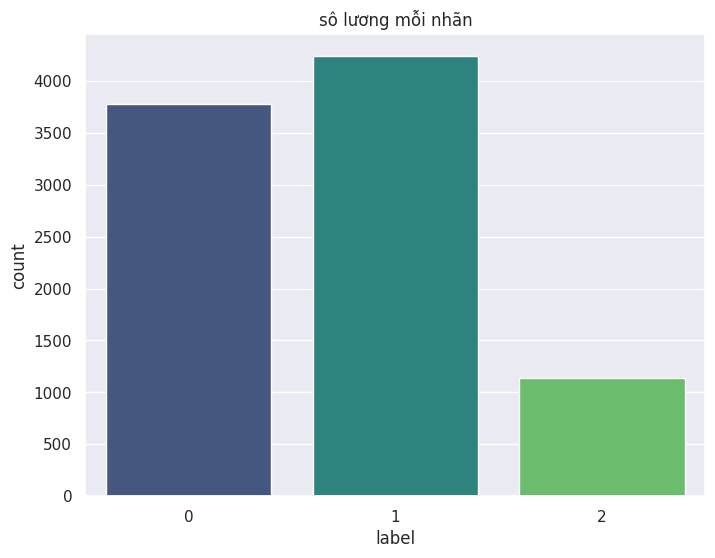

In [167]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=pd.DataFrame(y), palette='viridis')

# Hiển thị biểu đồ
plt.title('sô lương mỗi nhãn')
plt.show()


In [168]:
data['review'] = X_tokenize

In [169]:
vectorizer =  TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [170]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)
y_pred_nb = nb_model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       764
           1       0.80      0.92      0.86       850
           2       0.89      0.11      0.20       217

    accuracy                           0.83      1831
   macro avg       0.85      0.65      0.65      1831
weighted avg       0.83      0.83      0.79      1831



In [171]:
import warnings
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted, check_non_negative
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.validation import _check_sample_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_array
from sklearn.utils.multiclass import _check_partial_fit_first_call

class MultinomialNBB(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior

    def count(self, X, Y):
        self.feature_count_ += safe_sparse_dot(Y.T, X)
        self.class_count_ += Y.sum(axis=0)

    def update_feature_log_prob(self, alpha):
        smoothed_fc = self.feature_count_ + alpha
        smoothed_cc = smoothed_fc.sum(axis=1)

        self.feature_log_prob_ = np.log(smoothed_fc/smoothed_cc.reshape(-1, 1))

    def update_class_log_prior(self, class_prior=None):
        n_classes = len(self.classes_)
        if class_prior is not None:
            self.class_log_prior_ = np.log(class_prior)
        elif self.fit_prior:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                log_class_count = np.log(self.class_count_)
            self.class_log_prior_ = log_class_count - np.log(self.class_count_.sum())
        else:
            self.class_log_prior_ = np.full(n_classes, -np.log(n_classes))

    def init_counters(self, n_classes, n_features):
        self.class_count_ = np.zeros(n_classes, dtype=np.float64)
        self.feature_count_ = np.zeros((n_classes, n_features), dtype=np.float64)

    def fit(self, X, y, sample_weight=None):
        _, n_features = X.shape

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_

        if sample_weight is not None:
            Y = Y.astype(np.float64, copy=False)
            sample_weight = _check_sample_weight(sample_weight, X)
            sample_weight = np.atleast_2d(sample_weight)
            Y *= sample_weight.T

        class_prior = self.class_prior
        n_classes = Y.shape[1]
        self.init_counters(n_classes, n_features)
        self.count(X, Y)
        alpha = self.alpha
        self.update_feature_log_prob(alpha)
        self.update_class_log_prior(class_prior=class_prior)
        return self

    def joint_log_likelihood(self, X):
        return safe_sparse_dot(X, self.feature_log_prob_.T) + self.class_log_prior_

    def predict(self, X):
        jll = self.joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]


In [172]:
model =  MultinomialNBB()
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       764
           1       0.80      0.92      0.86       850
           2       0.89      0.11      0.20       217

    accuracy                           0.83      1831
   macro avg       0.85      0.65      0.65      1831
weighted avg       0.83      0.83      0.79      1831



In [173]:
false_predictions = np.where(y_test != y_pred)[0]

In [174]:
false_predictions

array([   1,    2,    6,   21,   36,   38,   39,   42,   59,   61,   63,
         68,   75,   76,   86,   87,   89,   95,  105,  114,  121,  129,
        137,  150,  165,  174,  177,  179,  189,  190,  197,  202,  203,
        213,  219,  222,  236,  238,  240,  246,  263,  265,  272,  275,
        279,  286,  288,  289,  290,  291,  299,  300,  306,  310,  314,
        317,  319,  322,  327,  335,  337,  338,  340,  341,  343,  349,
        357,  373,  375,  376,  384,  387,  393,  407,  414,  426,  427,
        444,  446,  471,  472,  475,  476,  477,  481,  482,  490,  504,
        506,  526,  527,  540,  548,  558,  560,  568,  573,  580,  582,
        587,  588,  589,  606,  610,  617,  625,  626,  630,  638,  644,
        645,  649,  652,  654,  657,  659,  662,  663,  667,  669,  675,
        676,  678,  685,  688,  692,  694,  699,  716,  724,  734,  740,
        742,  744,  745,  748,  754,  755,  761,  767,  773,  782,  794,
        795,  798,  804,  809,  811,  812,  818,  8

In [175]:
for i in false_predictions:
  print(X_test[i])
  print("label: ",np.array(y_test)[i], "predict: ", y_pred[i])

danhankhoga1kycon850glamangiandoi
label:  2 predict:  1
chất_liệu kích_cỡ màu_sắc kiểu_dáng chiều cao cân nặng vải không như hình không đáng mua
label:  0 predict:  1
cơm cháy thì ngon nhưng khô gà ít không thấy luôn mua lần 2 nên hơi bị thất_vọng mua dùm người_ta nữa nên bị người_ta nói
label:  2 predict:  1
đóng_gói không được cẩn_thận cho lắm nhưng giao hàng cũng rất nhanh
label:  2 predict:  1
không giống hình
label:  2 predict:  0
em có_thể làm gì đâu ý ý gì đâu ý nhỉ không có gì ăn_không có tiền ăn
label:  2 predict:  0
hơi mặn và ngọt_nhạt xíu la ngon giao nhanh se_ung ho lần sau
label:  2 predict:  1
em thấy chất vải không được dày lắm
label:  2 predict:  1
haht sấy giòn nhưng mà ngọt như mứt vậy bao_bì ghi có óc chó hạnh_nhân hạt điều nhưng không thấy đâu
label:  2 predict:  0
chất_liệu vải dày sờ hơi thô_ráp bề_mặt cảm_giác hơi xù lông kích_cỡ đúng thông shop màu_sắc giống hình mô_tả kiểu_dáng bagy ống rộng bắp_đùi bắp_chân to hoặc chân vòng_kiềng thì nên mua chiều cao cân nặ